In [1]:
import os
import sys
sys.path.extend(["../..", "."])

from nebula.misc import get_path
SCRIPT_PATH = get_path(type="notebook")
REPO_ROOT = os.path.join(SCRIPT_PATH, "..", "..")

from nebula.evaluation import read_cv_data_splits, read_cv_metrics_folder
from nebula.evaluation.roc import allign_metrics, report_alligned_metrics, get_roc, get_preds
from nebula.misc.plots import plot_roc_curve, plot_cv_metrics_dict
from nebula.models import TransformerEncoderChunks
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pickle
import json
import torch

RUN_TYPES = ['api_file_network_registry', 'api_only_full', 'api_only_name', 'file_network_registry', 'all']
RUN_NAME = "fields"

INFOLDER = "out_fields"
RUN_END_FILTER = "r1763_t5"
run_folders = [x for x in os.listdir(INFOLDER) if x.startswith("cv") and x.endswith(RUN_END_FILTER)]
LIMIT = "full"

VOCAB = 50000
SEQ_LEN = 512

### Note -- here 'all' was run with BPE tokenizer, and all others with 'whitespace' (unintentionally)

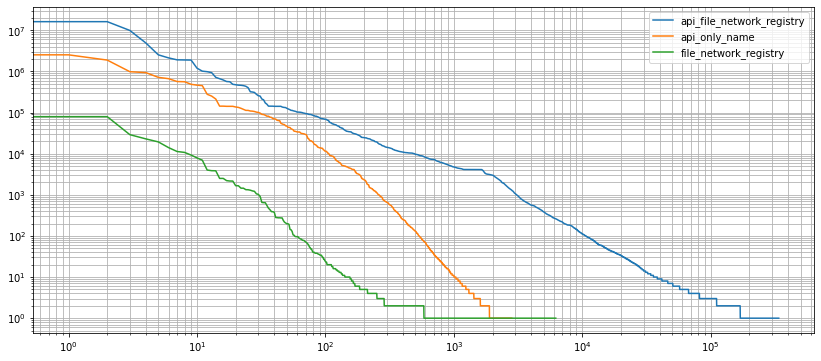

In [31]:
counters = {}

fig, ax = plt.subplots(1,1, figsize=(14,6))

for run_type in RUN_TYPES:
    if run_type in ["api_only_full", 'all']:
        # for some reason "api_only_full" has practically the same token counts as "api_file_network_registry"
        # it might be related to pre-processing that strips all the punctuation?
        # i.e. text = text.translate(str.maketrans('', '', string.punctuation))
        continue
    counter_file = os.path.join(INFOLDER, f"{run_type}_vocab_{VOCAB}_seqlen_{SEQ_LEN}", f"tokenizer_{VOCAB}_counter.json")
    with open(counter_file) as f:
        counter = json.load(f)
    # sort by value
    counter = {k: v for k, v in sorted(counter.items(), key=lambda item: item[1], reverse=True)}
    counters[run_type] = counter
    # plot all token counts
    ax.plot(list(counter.values()), label=run_type)
ax.set_yscale("log")
ax.set_xscale("log")
# scale all ticks
ax.grid(True, which="both")
_ = ax.legend()

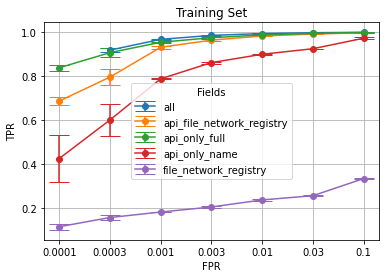

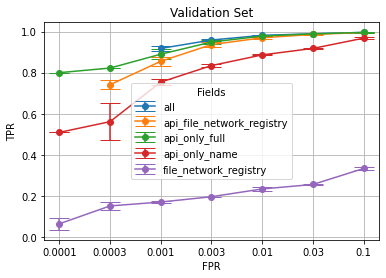

In [2]:
def training_filter(file):
    return file.endswith("training.json")
def validation_filter(file):
    return file.endswith("validation.json")
def key_extractor(file):
    return file.split("_")[:-2]

metrics_train = {}
metrics_val = {}
for folder in run_folders:
    metrics_train.update(read_cv_metrics_folder(os.path.join(INFOLDER, folder), key_extractor, training_filter))
    metrics_val.update(read_cv_metrics_folder(os.path.join(INFOLDER, folder), key_extractor, validation_filter))

TITLE = RUN_NAME.capitalize()
newkeys = [x for x in metrics_train.keys()]
ax = plot_cv_metrics_dict(metrics_train, "tpr", legendTitle=TITLE, legendValues=newkeys)
ax.set_title("Training Set")

ax = plot_cv_metrics_dict(metrics_val, "tpr", legendTitle=TITLE, legendValues=newkeys)
_ = ax.set_title("Validation Set")

In [3]:
models = defaultdict(dict)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for run_type in RUN_TYPES:
    nebula_vocab_file = os.path.join(INFOLDER, f"{run_type}_vocab_{VOCAB}_seqlen_{SEQ_LEN}", f"tokenizer_{VOCAB}_vocab.json")

    with open(nebula_vocab_file) as f:
        nebula_vocab = json.load(f)
    models[run_type]['class'] = TransformerEncoderChunks
    models[run_type]['config'] = {
        "vocab_size": len(nebula_vocab),
        "maxlen": SEQ_LEN,
        "chunk_size": 64,
        "dModel": 64,  # embedding & transformer dimension
        "nHeads": 8,  # number of heads in nn.MultiheadAttention
        "dHidden": 256,  # dimension of the feedforward network model in nn.TransformerEncoder
        "nLayers": 2,  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
        "numClasses": 1, # binary classification
        "hiddenNeurons": [64],
        "layerNorm": False,
        "dropout": 0.3,
        "mean_over_sequence": False,
        "norm_first": True
    }

In [4]:
metrics_val = defaultdict(list)
model_files = defaultdict(list)
for folder in run_folders:
    key = '_'.join(folder.split("_")[1:-3])
    existing_pickle = os.path.join(INFOLDER, f"{key}_roc_metrics_val_{RUN_END_FILTER}.pkl")
    if os.path.exists(existing_pickle):
        metrics = pickle.load(open(existing_pickle, "rb"))
    else:
        metrics = []
        print(f"[*] In process: {key}")

        folder = os.path.join(INFOLDER, folder)
        data_splits = read_cv_data_splits(folder)
        
        train_folder = os.path.join(folder, "training_files")
        model_files[key] = [os.path.join(train_folder, x) for x in os.listdir(train_folder) if x.endswith(".torch")]
        
        for i, model_file in enumerate(model_files[key]):
            print(f"[*] Running ROC for split: {i}")
            model = models[key]['class'](**models[key]['config']).to(device)
            model.load_state_dict(torch.load(model_file))
            model.eval()
            y_true, y_pred = get_preds(
                model,
                data_splits[i]["X_test"],
                data_splits[i]["y_test"],
                model_name=f"{key}_split_{i}",
                batch_size=96
            )
            fpr, tpr, roc_auc, f1, recall, precision, acc = get_roc(y_true, y_pred, metrics_full=True)
            metrics.append([fpr, tpr, roc_auc, f1, recall, precision, acc])
        pickle.dump(metrics, open(existing_pickle, "wb"))
    metrics_val[key] = metrics

base_fpr_val, tprs_mean_val, tprs_std_val = allign_metrics(metrics_val)

[*] In process: all
[*] Running ROC for split: 0
Evaluating all_split_0 | Size: 5397313...


100%|██████████| 317/317 [00:10<00:00, 29.28it/s]


[*] Running ROC for split: 1
Evaluating all_split_1 | Size: 5397313...


100%|██████████| 317/317 [00:09<00:00, 32.20it/s]


[*] Running ROC for split: 2
Evaluating all_split_2 | Size: 5397313...


100%|██████████| 317/317 [00:10<00:00, 29.24it/s]


,0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,AUC,F1,Recall,Precision,Accuracy
all,0.434969,0.617895,0.894529,0.958470,0.980996,0.988911,0.996019,0.998856,0.998110,0.988421,0.988585,0.988269,0.983325
api_file_network_registry,0.442850,0.672602,0.847337,0.936798,0.970849,0.986162,0.995005,0.998814,0.997617,0.985766,0.984900,0.986668,0.980769
api_only_full,0.595763,0.682088,0.898205,0.950637,0.977740,0.988494,0.995433,0.998970,0.998066,0.987172,0.986919,0.987444,0.982660
api_only_name,0.272529,0.437574,0.756845,0.838777,0.886200,0.917985,0.971438,0.998192,0.990939,0.957293,0.943268,0.971771,0.943121
file_network_registry,0.066045,0.125491,0.172227,0.200527,0.234287,0.259689,0.334736,0.553350,0.720657,0.872649,0.989935,0.780212,0.792044


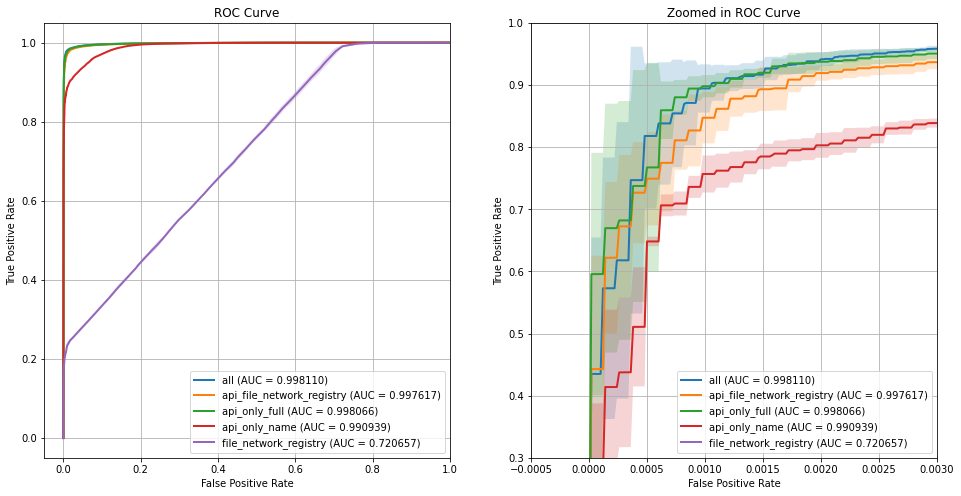

In [5]:
df, axs_val = report_alligned_metrics(
    base_fpr_val,
    tprs_mean_val,
    tprs_std_val,
    metrics_val,
    xlim=[-0.0005, 0.003],
    ylim=[0.3, 1.0],
    metrics_full=True
)
df

## Test set ROCs

In [6]:
model_files = defaultdict(list)
metrics_test = defaultdict(list)
for folder in run_folders:
    key = '_'.join(folder.split("_")[1:-3])
    existing_pickle = os.path.join(INFOLDER, f"{key}_roc_metrics_test_{RUN_END_FILTER}.pkl")
    if os.path.exists(existing_pickle):
        metrics = pickle.load(open(existing_pickle, "rb"))
    else:
        metrics = []
        if key == 'file_network_registry':
            continue
        print(f"[*] In process: {key}")
        folder = os.path.join(INFOLDER, folder)

        data_folder = [x for x in os.listdir(INFOLDER) if str(key) in x and "vocab" in x][0]
        X_test = np.load(os.path.join(INFOLDER, data_folder, f"x_test_{LIMIT}.npy"))
        y_test = np.load(os.path.join(INFOLDER, data_folder, f"y_test_{LIMIT}.npy"))
        
        train_folder = os.path.join(folder, "training_files")
        model_files[key] = [os.path.join(train_folder, x) for x in os.listdir(train_folder) if x.endswith(".torch")]

        for i, model_file in enumerate(model_files[key]):
            print(f"[*] Running ROC for split: {i}")
            model = models[key]['class'](**models[key]['config']).to(device)
            model.load_state_dict(torch.load(model_file))
            model.eval()
            y_true, y_pred = get_preds(
                model,
                X_test,
                y_test,
                model_name=f"{key}_split_{i}",
                batch_size=64
            )
            fpr, tpr, roc_auc, f1, recall, precision, acc = get_roc(y_true, y_pred, metrics_full=True)
            metrics.append([fpr, tpr, roc_auc, f1, recall, precision, acc])
        pickle.dump(metrics, open(existing_pickle, "wb"))
    metrics_test[key] = metrics


[*] In process: all
[*] Running ROC for split: 0
Evaluating all_split_0 | Size: 5397313...


100%|██████████| 272/272 [00:05<00:00, 46.72it/s]


[*] Running ROC for split: 1
Evaluating all_split_1 | Size: 5397313...


100%|██████████| 272/272 [00:05<00:00, 46.40it/s]


[*] Running ROC for split: 2
Evaluating all_split_2 | Size: 5397313...


100%|██████████| 272/272 [00:06<00:00, 43.06it/s]


,0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,AUC,F1,Recall,Precision,Accuracy
all,0.001843,0.005069,0.015704,0.034422,0.083307,0.148889,0.389344,0.803297,0.804874,0.749475,0.721685,0.792803,0.750637
api_file_network_registry,0.291999,0.340104,0.513879,0.661491,0.755209,0.849906,0.906767,0.958949,0.967487,0.906396,0.850899,0.969690,0.905057
api_only_full,0.218668,0.355241,0.523875,0.626467,0.775391,0.846913,0.902691,0.944344,0.960173,0.907494,0.858343,0.962884,0.905421
api_only_name,0.034918,0.054380,0.110213,0.153426,0.215109,0.296283,0.424714,0.678823,0.761526,0.445949,0.294480,0.918658,0.604814


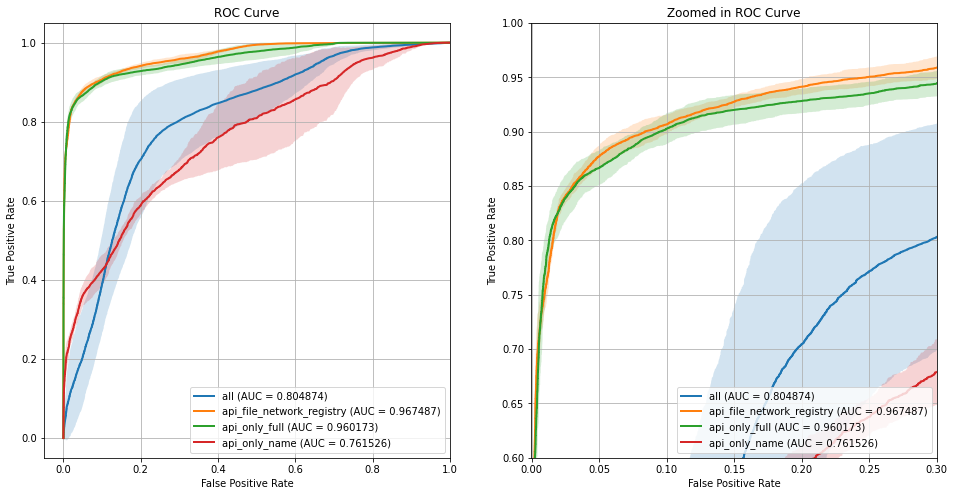

In [7]:
base_fpr_test, tprs_mean_test, tprs_std_test = allign_metrics(metrics_test)

df, axs_test = report_alligned_metrics(
    base_fpr_test,
    tprs_mean_test,
    tprs_std_test,
    metrics_test,
    metrics_full=True
)
df

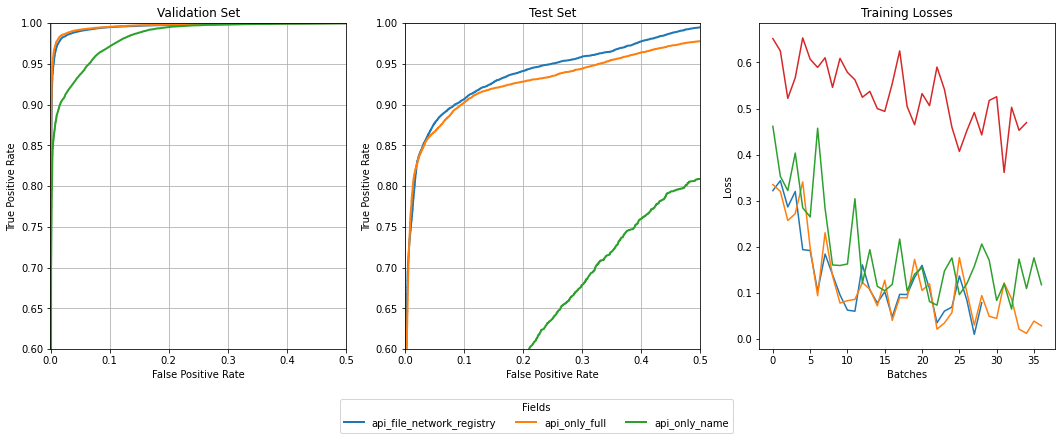

In [13]:
YLIM = [0.6, 1]
XLIM = [-0.0005, 0.5]
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
for key in tprs_mean_val:
    if key == 'file_network_registry': # erros out for some reason, but do not care about that really
        continue
    plot_roc_curve(base_fpr_val, tprs_mean_val[key], model_name=key, ax=axs[0], ylim=YLIM, xlim=XLIM)
    plot_roc_curve(base_fpr_test, tprs_mean_test[key], model_name=key, ax=axs[1], ylim=YLIM, xlim=XLIM)

axs[0].set_title("Validation Set")
axs[1].set_title("Test Set")
#[ax.legend(loc="lower right", title="Learning rate") for ax in axs[0:2]]
[ax.set_ylabel("True Positive Rate") for ax in axs[0:2]]
[ax.set_xlabel("False Positive Rate") for ax in axs[0:2]]
[ax.grid() for ax in axs[0:2]]

start = 100
n = 70
for folder in run_folders:
    key = folder.split("_")[1]
    train_folder = os.path.join(INFOLDER, folder, "training_files")
    train_losses = [os.path.join(train_folder, x) for x in os.listdir(train_folder) if "trainLosses" in x][0]
    loss_mean = np.load(train_losses)[start::n]    
    axs[2].plot(loss_mean, label=key)
axs[2].set_xlabel("Batches")
axs[2].set_ylabel("Loss")
axs[2].set_title("Training Losses")

# make one common legend below the plots so it does not overlap with the plots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=5, title=RUN_NAME.capitalize(), bbox_to_anchor=(0.5, -0.08))

_ = fig.savefig(os.path.join(REPO_ROOT, "img", f"results_{'_'.join(RUN_NAME.split(' '))}.png"), dpi=300, bbox_inches='tight')